In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
stations = Base.classes.station
measurements = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(measurements.date).order_by(measurements.date.desc()).first()
print(recent_date)

('2017-08-23',)


Last Year To Date: 2016-08-23


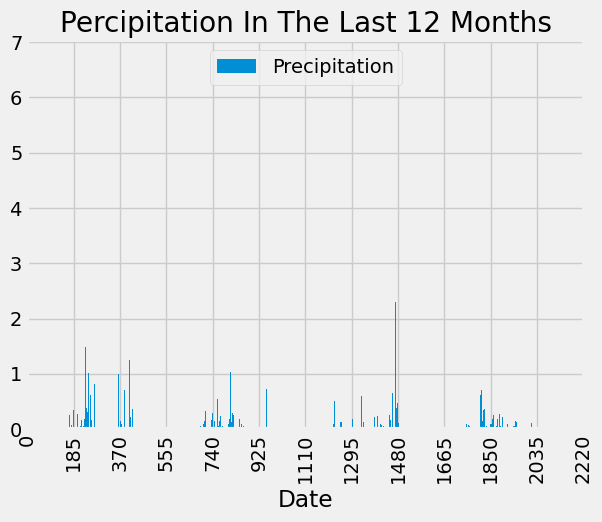

In [65]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
#lytd = session.query(measurements.date).filter(measurements.date > '2016-08-23').order_by(measurements.date).all()
query_date = dt.date(2017, 8, 23)
# Calculate the date one year from the last date in data set.
lyt_date = query_date - dt.timedelta(days=365)
print("Last Year To Date:", lyt_date)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(measurements.date, measurements.prcp).filter(measurements.date > lyt_date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])
# Sort the dataframe by date
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)
#df.set_index('Date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
step = len(df)//12

df.plot(kind='bar', title='Percipitation In The Last 12 Months', xticks=range(0, len(df), step))
#plt.style.use('fivethirtyeight')
plt.xticks(rotation=90)
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df.groupby('Date').agg(['mean', 'median', 'var', 'std', 'sem'])
print(summary_stats)

           Precipitation                                     
                    mean median       var       std       sem
Date                                                         
2016-08-24      1.555000  1.800  0.706510  0.840541  0.343150
2016-08-25      0.077143  0.080  0.005157  0.071813  0.027143
2016-08-26      0.016667  0.015  0.000267  0.016330  0.006667
2016-08-27      0.064000  0.020  0.006680  0.081731  0.036551
2016-08-28      0.516667  0.140  0.620427  0.787672  0.321566
...                  ...    ...       ...       ...       ...
2017-08-19      0.030000  0.000  0.002700  0.051962  0.030000
2017-08-20      0.005000  0.005  0.000050  0.007071  0.005000
2017-08-21      0.193333  0.020  0.100933  0.317700  0.183424
2017-08-22      0.166667  0.000  0.083333  0.288675  0.166667
2017-08-23      0.132500  0.040  0.046225  0.215000  0.107500

[365 rows x 5 columns]


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(measurements.station).distinct().count()
station_count

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
#station_frequency = session.query(meaurements.station)
    #sort_by(measurements.station)
    #print(station_frequency)

station_frequency = session.query(measurements.station, func.count(measurements.station).label('observation_count')).\
                    group_by(measurements.station).\
                    order_by(func.count(measurements.station).desc()).all()

for station in station_frequency:
    print(station.station, station.observation_count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [measurements.station,
       func.min(measurements.tobs),
       func.max(measurements.tobs),
       func.avg(measurements.tobs)]  

most_active = session.query(*sel).\
    filter(measurements.station == 'USC00519281')

#most_active.all()

df = pd.DataFrame(most_active, columns=['stationID', 'lowest temperature', 'highest temperature', 'average temperature'])
df.set_index('stationID', inplace=True)
df

,lowest temperature,highest temperature,average temperature
stationID,,,
USC00519281,54.0,85.0,71.663781


<Axes: title={'center': 'Temperature Observation For Most Active Station'}, xlabel='Temperature', ylabel='Frequency'>

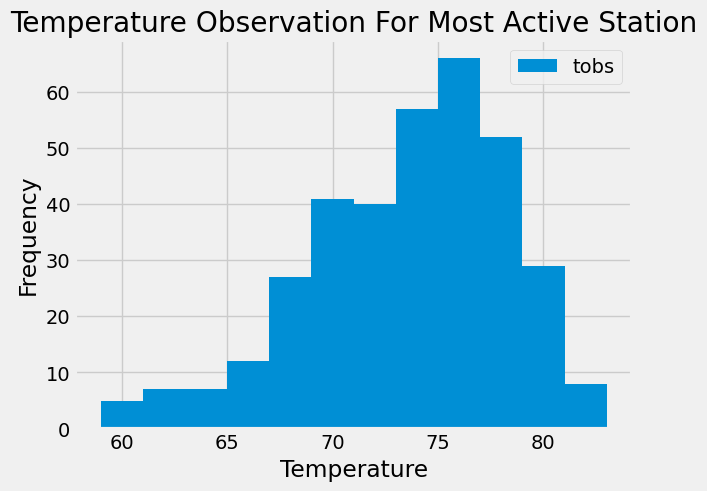

In [54]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_ttm = session.query(measurements.date, measurements.tobs).\
    filter(measurements.date > lyt_date).\
    filter(measurements.station == 'USC00519281')

most_active_df = pd.DataFrame(most_active_ttm)
most_active_df.plot(kind='hist', bins=12, xlabel='Temperature', title='Temperature Observation For Most Active Station')


# Close Session

In [16]:
# Close Session
session.close()